from https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset/code

## Part 1
Just set a baseline, we fit a model to our data.
But using standard local files

In [117]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [34]:
df=pd.read_csv('twitter_MBTI.csv')
df.head()

,Unnamed: 0,text,label
0,0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,1,@Hispanthicckk Being you makes you look cute||...,intj
2,2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


(7811, 3)


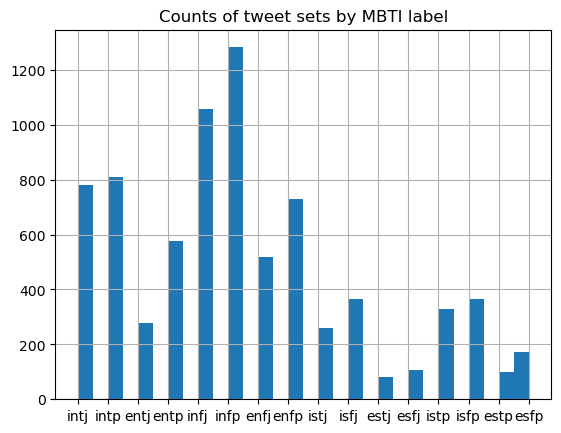

In [136]:
print(df.shape)
df.label.hist(bins=30);
plt.title('Counts of tweet sets by MBTI label');

Develop the text sanitisation.
NB this will be reused in the hadoop mapper

In [37]:
import re
from nltk.stem import WordNetLemmatizer
# do these one time
#import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def validword(s):    
    if s.isascii():  # ignore emtocicon and non-english text
        # ignore url/handle/3 or more key mashing
        if re.match(r'^http|^@|(.)\1{2,}',s):
            return ''
        # only allow letters
        elif re.match(r'^[a-zA-Z]*$',s):
            return lemmatizer.lemmatize(s.lower())
        else:
            return ''
    else:
        return ''
test=pd.Series(['okay','corpora','xxx @yz zzz','start https://spug end ||| more','dokey'])
for w in test:
    print(w,'=>',validword(w))

okay => okay
corpora => corpus
xxx @yz zzz => 
start https://spug end || more => 
dokey => dokey


In [40]:
def parsetweets(s):
    rv=''
    for tweet in s.split('|||'):
        for word in tweet.split():
            rv=rv+' '+validword(word)
    return rv
def clean_tweets(s):
    return s.apply(parsetweets)

clean_tweets(test)
df.text=clean_tweets(df.text)
# delete any rows where nothing left of tweet
df=df[df.text != '']

In [148]:
# get fully balanced sample
#( manually downsampling for simplicity)
# firstly get labels
types=df.label.unique()
print(types)
# downsample to smallest class
nsamp=int(df.groupby(["label"]).count().min()[0])
working_df=df.head(1)
for t in types:    
    working_df=pd.concat([working_df,df.query('label=="'+t+'"').sample(nsamp)])
    #print(t,working_df.shape)
# clean it
working_df.text=clean_tweets(working_df.text)
print(f'Downsampled to {nsamp} for all classes')


['intj' 'intp' 'entj' 'entp' 'infj' 'infp' 'enfj' 'enfp' 'istj' 'isfj'
 'estj' 'esfj' 'istp' 'isfp' 'estp' 'esfp']
Downsampled to 81 for all classes


In [149]:
working_df

,Unnamed: 0,text,label
0,0,the pope is this is a catholic dogma it mean ...,intj
386,386,nothing on main headline but i saw this what ...,intj
609,609,terrible how people can dangerously over anal...,intj
5881,5881,marked a and and tomorrow by gabrielle zevin ...,intj
7350,7350,like year ago but ohmygod le w h a t mashiro ...,intj
...,...,...,...
1913,1913,taurus thank ty thank thank thank you thank u...,esfp
598,598,so sad my bts no pls im so sad imgojng myself...,esfp
3532,3532,i found the tweet prediction im so happy ran ...,esfp
1907,1907,cringe is not real it is just a social medium...,esfp


In [43]:
# rescale with tf-idf
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(min_df=5, stop_words='english',ngram_range=(1,1),norm=None).fit(working_df.text)
X = vectorizer.transform(working_df.text)
y=working_df.label
# find maximum value for each of the features over dataset:
max_value = X.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())
print(f'{len(feature_names)} features')
print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-40:]]))

10149 features
Features with lowest tfidf:
['opened' 'including' 'hanging' 'birth' 'information' 'effect' 'core'
 'confirmed' 'passing' 'caption' 'constant' 'opposite' 'stealing'
 'illness' 'ground' 'closest' 'habit' 'zone' 'anger' 'forgetting']
Features with highest tfidf: 
['help' 'medley' 'terrorist' 'saudi' 'eth' 'safe' 'marketing' 'capable'
 'enhypen' 'track' 'hi' 'ka' 'lee' 'sunoo' 'jackson' 'followed'
 'unfollowed' 'selling' 'update' 'flight' 'vote' 'shopee' 'florida' 'moot'
 'follow' 'sector' 'checked' 'ty' 'automatically' 'rt' 'mint' 'aries'
 'pinned' 'bbl' 'retweet' 'cr' 'wordle' 'participate' 'aye' 'kst']


In [44]:
from sklearn.model_selection import train_test_split
# setup for fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
# feature_names = vect.get_feature_names()
# print("Number of features: {}".format(len(feature_names)))
# print("First 20 features:\n{}".format(feature_names[:20]))
# print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
# print("Every 2000th feature:\n{}".format(feature_names[::2000]))

In [47]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier # 0.38
from sklearn.neighbors import KNeighborsClassifier # brutal
from sklearn.neural_network import MLPClassifier # poor 0.12
from sklearn.ensemble import RandomForestClassifier # 0.4
from sklearn.metrics import classification_report
#scores = cross_val_score(LogisticRegression(max_iter=500), X_train, y_train, cv=2)
#print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
reg=RandomForestClassifier().fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(classification_report(y_pred,y_test,target_names=types))

              precision    recall  f1-score   support

        intj       0.18      0.26      0.21        19
        intp       0.30      0.48      0.37        21
        entj       0.35      0.23      0.28        35
        entp       0.31      0.45      0.37        22
        infj       0.45      0.20      0.27        51
        infp       0.32      0.26      0.29        27
        enfj       0.22      0.18      0.20        28
        enfp       0.25      0.43      0.32        14
        istj       0.37      0.48      0.42        23
        isfj       0.29      0.18      0.22        44
        estj       0.26      0.35      0.30        17
        esfj       0.25      0.27      0.26        22
        istp       0.50      0.34      0.41        35
        isfp       0.33      0.33      0.33        27
        estp       0.31      0.50      0.38        18
        esfp       0.29      0.45      0.35        20

    accuracy                           0.31       423
   macro avg       0.31   

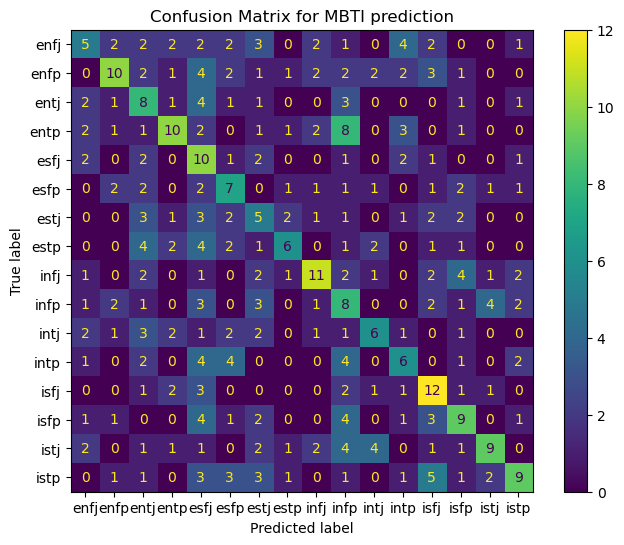

In [48]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important: 
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=reg.classes_)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for MBTI prediction')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

It's not great, but shows there is a model to be discovered

## Part Two  , the actual object of the exercise
Now do likewise, with same data.  
Except the data has been map reduced into hbase (see document)

In [49]:
#!pip install happybase

In [127]:
import happybase

connection = happybase.Connection('localhost')
table = connection.table('wordcount')

In [110]:
table.row(b'1')

{b'cf:count': b'51',
 b'cf:doc_id': b'000000000',
 b'cf:label': b'intj',
 b'cf:word': b'a'}

We can look at distribution of data using happybase.  
Note this is alternate to sql group by.  
It's not terribly efficient - we're doing all the processing client side

In [128]:
groupby = b'cf:label'
counts = {}
# Scan the table and group the data by the specified column
for _, data in table.scan(columns=[groupby]):
    label = data[groupby]
    if label not in counts:
        counts[label] =0
    counts[label]=counts[label]+1

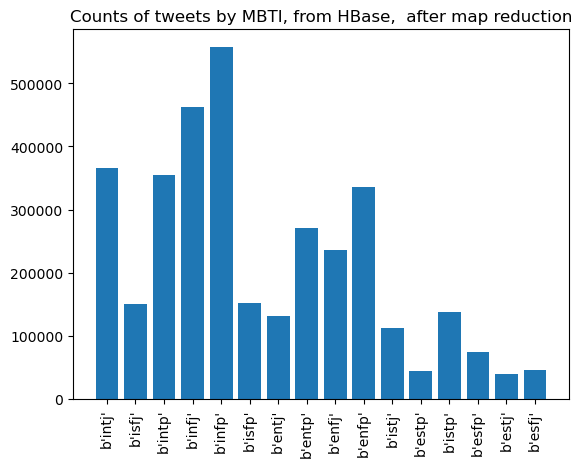

In [129]:
# do a simple plot to display our aggregated totals
fig,ax=plt.subplots()
ax.bar(range(len(counts)), list(counts.values()),tick_label=list(counts.keys()));
ax.set_xticklabels(labels=list(counts.keys()) ,rotation=90);
ax.set_title('Counts of tweets by MBTI, from HBase,  after map reduction');

That was all well and good, but it would be preferrable to manipulate the data using Pandas native DataFrames.   
Accordingly we use Happybase to convert

In [56]:
rows = table.scan()

In [57]:
# furthermore
data = [row[1] for row in rows]     

In [58]:
hdf = pd.DataFrame(data)

In [59]:
hdf.shape

(3470604, 4)

In [60]:
hdf.head()

,b'cf:count',b'cf:doc_id',b'cf:label',b'cf:word'
0,b'51',b'000000000',b'intj',b'a'
1,b'1',b'000000000',b'intj',b'adoration'
2,b'8',b'000000000',b'intj',b'church'
3,b'1',b'000000000',b'intj',b'bien'
4,b'1',b'000000002',b'intj',b'awful'


type and rename to more user-friendly format

In [63]:
# rename columns and reassign data from binary 
hdf.rename(columns={b'cf:doc_id':'doc_id',b'cf:count':'ccount',b'cf:label':'label',b'cf:word':'word'},inplace=True)
hdf.ccount=hdf.ccount.astype(int)
hdf.label=hdf.label.astype(str)
hdf.word=hdf.word.astype(str)
hdf.doc_id=hdf.doc_id.astype(str)

In [65]:
hdf

,ccount,doc_id,label,word
0,51,000000000,intj,a
1,1,000000000,intj,adoration
2,8,000000000,intj,church
3,1,000000000,intj,bien
4,1,000000002,intj,awful
...,...,...,...,...
3470599,1,000000221,intp,experiencing
3470600,2,000000221,intp,eye
3470601,1,000000221,intp,face
3470602,1,000000221,intp,false


## The following effort was ultimately unnsuccessful.   
The reasons for this are explained in the document.    
The following workings can be ignored, but are included to illustrate the problems of this approach

In [89]:
# make it tiny, to develop
smallhdf=hdf[:50000]

In [90]:
print(f'{len(smallhdf.doc_id.unique())} docs, {len(smallhdf.label.unique())} classes')

15 docs, 12 classes


In [132]:
# we have individual document frequency, now generate total frequency
words_df=pd.DataFrame(data=smallhdf.word.unique(),columns=['word'])
word_dict=dict.fromkeys(smallhdf.word.unique(),0)
for w in word_dict.keys():
    #word_dict[w]=hdf.query('word==@w').ccount.sum()
    # going to hope this is quicker
    word_dict[w]=smallhdf[smallhdf.word==w].ccount.sum()

In [92]:
# save it (for when attempting to increase size)
# import pickle
# print(word_dict['the'])
# with open('word_dict.pickle', 'wb') as f:
#     pickle.dump(word_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('word_dict.pickle', 'rb') as f:
#     w2 = pickle.load(f)
# print(w2['the'])

from TfdIdVectorizer:    
The formula that is used to compute the tf-idf for a term t of a document d in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False), where n is the total number of documents in the document set and df(t) is the document frequency of t; the document frequency is the number of documents in the document set that contain the term t. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the idf formula above differs from the standard textbook notation that defines the idf as idf(t) = log [ n / (df(t) + 1) ]).

In [93]:
# tf/idf from https://monkeylearn.com/blog/what-is-tf-idf
import numpy as np
from collections import OrderedDict
import math
od=OrderedDict(word_dict)
from scipy.sparse import lil_matrix # lil_matrix recommended over csr_matrix
x=len(smallhdf.doc_id.unique())
y=len(od)
HX = lil_matrix((x,y))
Hy=[]
# how many token instances in totallity? 
total_tokens=sum(od.values())
i=0
docs=smallhdf.groupby(['doc_id'])[['label','word','ccount']]
for doc,frame in docs:
    Hy+=[frame.iloc[0].label]
    #print(f'|{frame.iloc[0].label}|')
    doctot=frame.ccount.sum()  # shudder to think of inefficency of doing this
    for index,row in frame.iterrows():
        # destination in sparse
        j=list(od.keys()).index(row.word)
        # document frequency
        tf=math.log(1+ od[row.word] / total_tokens)
        idf=row.ccount
        #print(f'[{i},{j}]')
        HX[i,j]=tf*idf
    i=i+1

In [94]:
HX,Hy

(<15x12790 sparse matrix of type '<class 'numpy.float64'>'
 	with 28694 stored elements in List of Lists format>,
 ['intj',
  'intj',
  'isfj',
  'isfj',
  'isfj',
  'intp',
  'isfp',
  'intj',
  'infj',
  'infp',
  'isfj',
  'infj',
  'intj',
  'intp',
  'infp'])

In [95]:
X,y

(<1281x10149 sparse matrix of type '<class 'numpy.float64'>'
 	with 363805 stored elements in Compressed Sparse Row format>,
 12790)

In [133]:
# fit something
X_train, X_test, y_train, y_test = train_test_split(HX, Hy, test_size=0.33, random_state=42)
reg=RandomForestClassifier().fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

        infj       0.00      0.00      0.00       0.0
        infp       0.00      0.00      0.00       0.0
        intj       0.00      0.00      0.00       2.0
        intp       0.00      0.00      0.00       0.0
        isfj       0.00      0.00      0.00       3.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



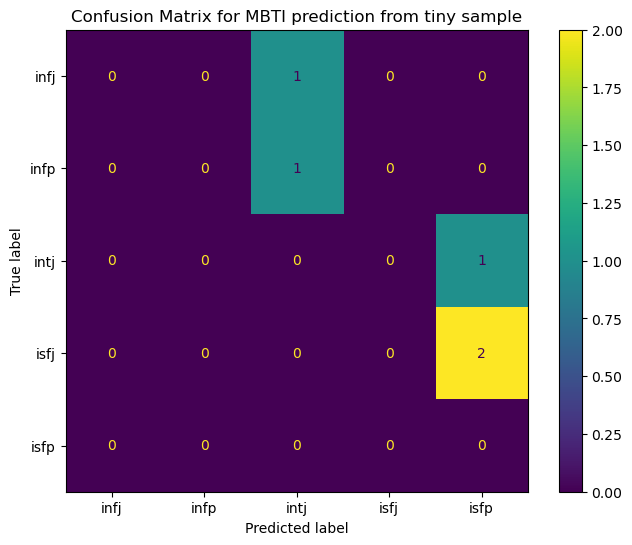

In [134]:
# and dare we? see what it looks like for such a small set?
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=reg.classes_)
# set the plot title using the axes object
ax.set(title='Confusion Matrix for MBTI prediction from tiny sample')
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);